# **INFO284 Machine Learning Exam, spring 2025**


# **Task 1 - Sentiment analysis**

## **Load data**

In [3]:
import pandas as pd

df = pd.read_csv('dataset/Hotel_Reviews.csv')

df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


## **Exploring the data**

### **Checking basic structure of the data**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

### **Overview of the distribution of the scores** 
We get an overview of the data to find out the max and min values of the reviewer scores and we also get an idea of the distribution of the reviewer scores.

count    515738.000000
mean          8.395077
std           1.637856
min           2.500000
25%           7.500000
50%           8.800000
75%           9.600000
max          10.000000
Name: Reviewer_Score, dtype: float64
2.5
10.0


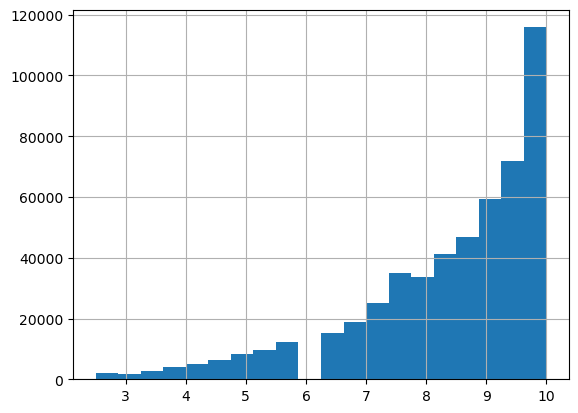

In [8]:
print(df['Reviewer_Score'].describe()) 

df['Reviewer_Score'].hist(bins=20)

print(df['Reviewer_Score'].min())
print(df['Reviewer_Score'].max())

From the histogram over we can see that the distribution of the scores is skewed towards the higher scores. This is not surprising as people tend to give higher scores when they are satisfied with a product or service.

## **Cleaning the review text**

Here we clean the review text. We remove 'No Negative' and 'No Positive' from the negative and positive reviews. 
Then we merge the negative and positive reviews into one column called 'Review'. This is done because it is easier to work with one column when doing the sentiment analysis.
After, we only keep the 'Review' and 'Reviewer_Score' columns because they are the only relevant columns for the sentiment analysis. All other columns are dropped. 
We also remove rows with missing values because they are not useful for the sentiment analysis.

In [ ]:
df['Negative_Review'] = df['Negative_Review'].apply(lambda x: x.replace('No Negative', ''))
df['Positive_Review'] = df['Positive_Review'].apply(lambda x: x.replace('No Positive', ''))

df['Review'] = df['Negative_Review'] + ' ' + df['Positive_Review']

df = df[['Review','Reviewer_Score']] 

df = df.dropna()

df.head() 

,Review,Reviewer_Score
0,I am so angry that i made this post available...,2.9
1,No real complaints the hotel was great great...,7.5
2,Rooms are nice but for elderly a bit difficul...,7.1
3,My room was dirty and I was afraid to walk ba...,3.8
4,You When I booked with your company on line y...,6.7


## **Transforming review scores to binary values**

Here we add a new column called 'Sentiment' which is 1 if the reviewer score is greater than or exactly 6.25 and 0 otherwise. 6.25 is chosen because it is exactly the middle value of the given scores in the reviews (2.5 to 10). This is done to make the sentiment analysis a binary classification problem.

In [9]:
# Adjust the reviewer score to be binary numeric values
df['Sentiment'] = df['Reviewer_Score'].apply(lambda x: 1 if x >= 6.25 else 0)

# Here we split the data into two dataframes based on the sentiment 
df_majority = df[df['Sentiment'] == 1]
df_minority = df[df['Sentiment'] == 0]

## **Adjusting for sentiment imbalance**
There is a heavy overweight of positive ('high' scores) in the dataset, so we need to downsample the positive reviews to get a more balanced dataset for our machine learning model to train and test on. By balancing the number of positive and negative reviews, we avoid the model being biased towards predicting the majority class which is positive reviews.

In [45]:
# Downsample majority class
df_majority_downsampled = df_majority.sample(len(df_minority))

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

## **Exploring the data after downsampling the positive reviews**

count    444544.000000
mean          8.209730
std           1.682885
min           2.500000
25%           7.100000
50%           8.650000
75%           9.600000
max          10.000000
Name: Reviewer_Score, dtype: float64
87486
253


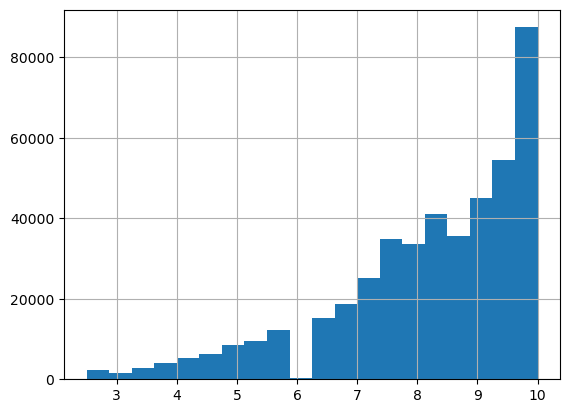

In [ ]:
df_balanced['Reviewer_Score'].hist(bins=20) 
print(df_balanced['Reviewer_Score'].describe()) 
print(df_balanced[df_balanced['Reviewer_Score'] == 10.0].shape[0])
print(df_balanced[df_balanced['Reviewer_Score'] == 6.0].shape[0])

The diagram illustrates how the downsampling changes the total amount of each score in the reviews. The total amount of 10.0 score reviews before the downsampling were for example 115 853, while now they are 87 486. 

From the plot we can see that the number of positive and negative reviews are now more balanced. This is good because it will make the machine learning model less biased towards predicting the majority class which is positive reviews. 

## **Preprocessing the review text**

Here we preprocess the review text by lowercasing the text, removing special characters, punctuation using regular expressions, and removing stopwords. We also tokenize and lemmatize the text.

In [10]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9_]+', '', text) 
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['Review'] = df['Review'].apply(preprocess_text)
df.head()

,Review,Reviewer_Score,Sentiment
0,i am so angry that i made this post available...,2.9,0
1,no real complaints the hotel was great great...,7.5,1
2,rooms are nice but for elderly a bit difficul...,7.1,1
3,my room was dirty and i was afraid to walk ba...,3.8,0
4,you when i booked with your company on line y...,6.7,1


### Tokenization

In [12]:
from nltk.tokenize import word_tokenize

def tokenize(text):
    return word_tokenize(text)

df['tokens'] = df['Review'].apply(tokenize)
df.head()

,Review,Reviewer_Score,Sentiment,tokens
0,angry made post available via possible sites u...,2.9,0,"[angry, made, post, available, via, possible, ..."
1,real complaints hotel great great location sur...,7.5,1,"[real, complaints, hotel, great, great, locati..."
2,rooms nice elderly bit difficult rooms two sto...,7.1,1,"[rooms, nice, elderly, bit, difficult, rooms, ..."
3,room dirty afraid walk barefoot floor looked c...,3.8,0,"[room, dirty, afraid, walk, barefoot, floor, l..."
4,booked company line showed pictures room thoug...,6.7,1,"[booked, company, line, showed, pictures, room..."


### Lemmatization

In [13]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize(tokens):
    lemmatized_tokens = []
    for token in tokens:
        try:
            lemmatized_token = lemmatizer.lemmatize(token)
        except Exception as e:
            lemmatized_token = token
        lemmatized_tokens.append(lemmatized_token)
    return lemmatized_tokens

df['lemmatized'] = df['tokens'].apply(lemmatize)

df.head()

,Review,Reviewer_Score,Sentiment,tokens,lemmatized
0,angry made post available via possible sites u...,2.9,0,"[angry, made, post, available, via, possible, ...","[angry, made, post, available, via, possible, ..."
1,real complaints hotel great great location sur...,7.5,1,"[real, complaints, hotel, great, great, locati...","[real, complaint, hotel, great, great, locatio..."
2,rooms nice elderly bit difficult rooms two sto...,7.1,1,"[rooms, nice, elderly, bit, difficult, rooms, ...","[room, nice, elderly, bit, difficult, room, tw..."
3,room dirty afraid walk barefoot floor looked c...,3.8,0,"[room, dirty, afraid, walk, barefoot, floor, l...","[room, dirty, afraid, walk, barefoot, floor, l..."
4,booked company line showed pictures room thoug...,6.7,1,"[booked, company, line, showed, pictures, room...","[booked, company, line, showed, picture, room,..."


## **Splitting the data into training and test sets**

In [14]:

from sklearn.model_selection import train_test_split
# Split the data into training and test sets (80% training, 20% testing)

X = df['lemmatized'].apply(lambda x: ' '.join(x))

y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## **MultinomialNB**

### **MultinomialNB with TF-IDF vectorizer**

The first model we will use for classifiying hotel reviews is MultinomialNB with TF-IDF vectorizer. We will use the TF-IDF vectorizer to convert the text data into numerical data that the model can work with. This model is chosen because it is a simple and fast model that is often used for text classification tasks. 

#### **Importing necessary libraries**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, GridSearchCV
import numpy as np

#### **Creating pipeline**
Because we are using TF-IDF vectorizer, it is most beneficial to use a pipeline because we are transforming the text data based on statistical properties of the dataset. Because of this, it's essential to ensure that all steps (vectorization and model training) are done correctly and consistently. 

In [ ]:
pipe = make_pipeline(TfidfVectorizer(min_df = 5, max_df=0.8, norm=None, stop_words= 'english'), MultinomialNB())

param_grid = {'multinomialnb__alpha': [0.001, 0.01, 0.1, 1, 10, 100], 'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)], 'tfidfvectorizer__use_idf': [True, False]}

grid = GridSearchCV(pipe, param_grid, cv=5)

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)
print(grid.score(X_test, y_test))

{'multinomialnb__alpha': 20, 'tfidfvectorizer__ngram_range': (2, 2)}
0.8555781768826197
0.8580292395393028


Comment the choice of parameters

#### Heat map of mean cross-validation accuracy as a function of the parameters ngram_range and alpha

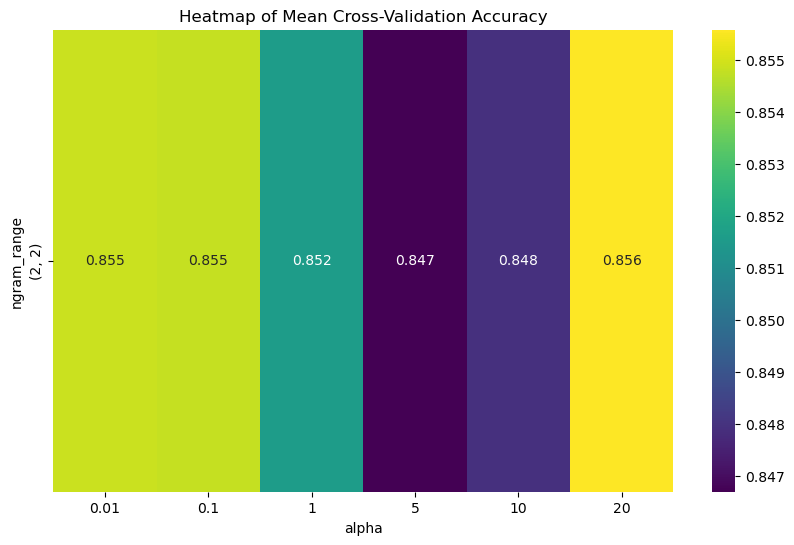

In [56]:
# implement Heat map of mean cross-validation accuracy as a function of the parameters ngram_range and alpha

import seaborn as sns
import matplotlib.pyplot as plt

# Get the number of unique values for each parameter
n_ngram_range = len(param_grid['tfidfvectorizer__ngram_range'])
n_alpha = len(param_grid['multinomialnb__alpha'])

# Reshape the scores array based on the number of unique values
scores = grid.cv_results_['mean_test_score'].reshape(n_ngram_range, n_alpha)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(scores, annot=True, fmt=".3f", xticklabels=param_grid['multinomialnb__alpha'], yticklabels=param_grid['tfidfvectorizer__ngram_range'], cmap='viridis')
plt.xlabel('alpha')
plt.ylabel('ngram_range')
plt.title('Heatmap of Mean Cross-Validation Accuracy')
plt.show()


#### **Printing and plotting the features with the highest and lowest tf-idf**

Features with lowest tfidf:
['location friendly' 'location near' 'staff clean' 'room friendly'
 'clean good' 'location breakfast' 'helpful location' 'polite helpful'
 'location easy' 'comfy room' 'small location' 'staff comfortable'
 'location comfortable' 'location helpful' 'helpful breakfast'
 'clean nice' 'beautiful room' 'location amazing' 'location quiet'
 'location right' 'room beautiful' 'helpful hotel' 'friendly hotel'
 'comfortable breakfast' 'breakfast delicious']
Features with highest tfidf: 
['extra bed' 'canning town' 'heating air' 'barcelona plaza' 'credit card'
 'add point' 'water lemon' 'xl room' 'cold water' 'pullout bed'
 'catalonia barcelona' 'superior twin' 'bath room' 'best western'
 'young man' 'bath tub' '60 pound' 'twin room' 'gym gym'
 'reservation department' 'manager manager' 'wash cloth' 'online payment'
 'shift receptionist' 'new wing']


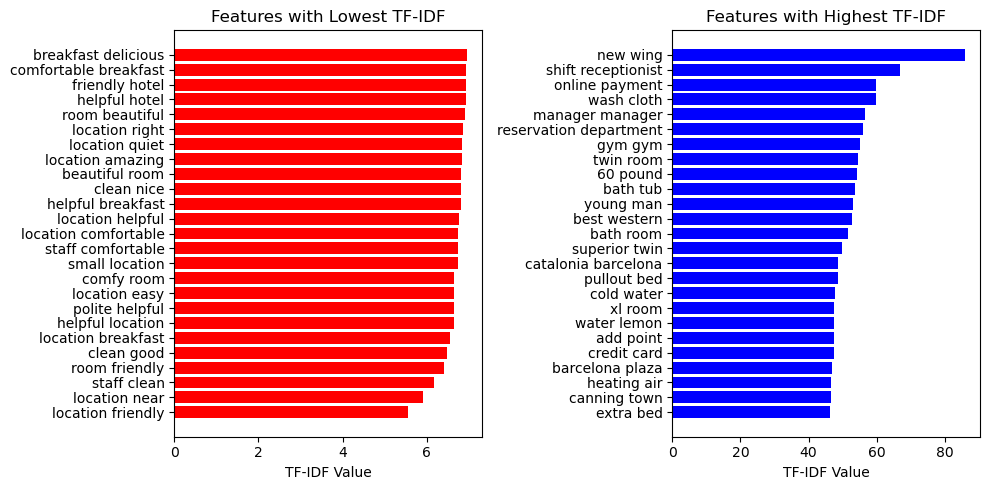

In [51]:
from matplotlib import pyplot as plt

vectorizer = grid.best_estimator_.named_steps['tfidfvectorizer']
X_train_transformed = vectorizer.transform(X_train)
max_value = X_train_transformed.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
feature_names = np.array(vectorizer.get_feature_names_out())
print("Features with lowest tfidf:\n{}".format(feature_names[sorted_by_tfidf[:25]]))
print("Features with highest tfidf: \n{}".format(feature_names[sorted_by_tfidf[-25:]]))
plt.figure(figsize=(10, 5))

# Plot features with lowest tfidf
plt.subplot(1, 2, 1)
plt.barh(feature_names[sorted_by_tfidf[:25]], max_value[sorted_by_tfidf[:25]], color='red')
plt.xlabel('TF-IDF Value')
plt.title('Features with Lowest TF-IDF')

# Plot features with highest tfidf
plt.subplot(1, 2, 2)
plt.barh(feature_names[sorted_by_tfidf[-25:]], max_value[sorted_by_tfidf[-25:]], color='blue')
plt.xlabel('TF-IDF Value')
plt.title('Features with Highest TF-IDF')

plt.tight_layout()
plt.show()

#### **Visualizing the top features that are most indicative of positive and negative reviews**

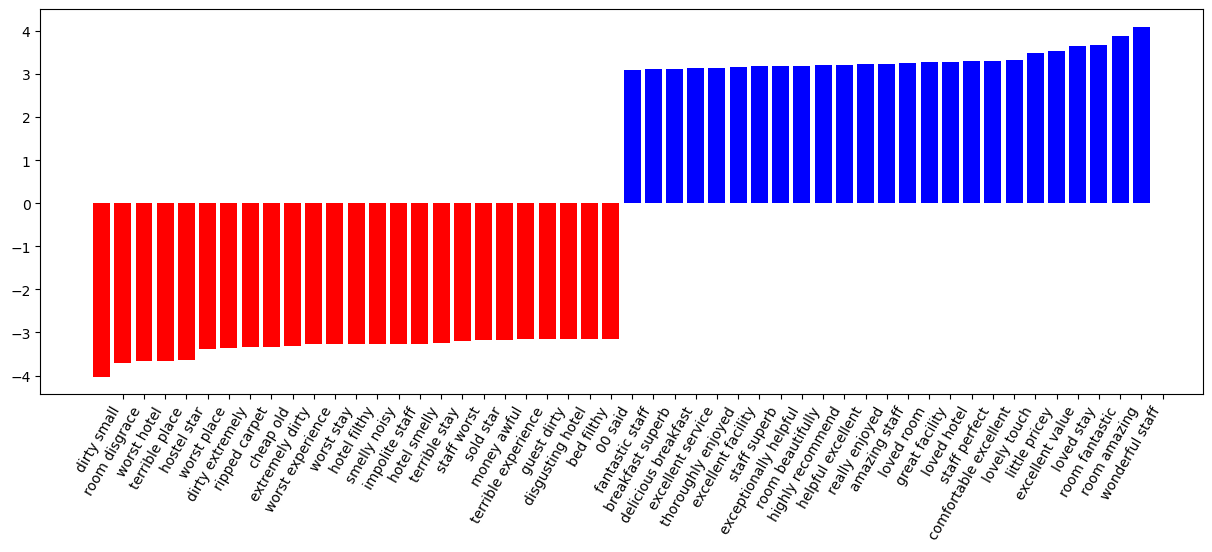

In [52]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    coef = classifier.feature_log_prob_[1] - classifier.feature_log_prob_[0]
    top_positive_coefficients = np.argsort(coef)[-n_top_features:]
    top_negative_coefficients = np.argsort(coef)[:n_top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

vectorizer = grid.best_estimator_.named_steps['tfidfvectorizer']
X_train_transformed = vectorizer.transform(X_train)
clf = grid.best_estimator_.named_steps['multinomialnb']
visualize_coefficients(clf, vectorizer.get_feature_names_out())


#### TF-IDF Vectorization & Naive Bayes Training

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

X_train_mnb_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_mnb_tfidf = tfidf_vectorizer.transform(X_test)

mnb_tfidf = MultinomialNB()

#### Cross Validation

In [ ]:
cv_scores_tfidf = cross_val_score(mnb_tfidf, X_train_mnb_tfidf, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores_tfidf}")
print(f"Mean cross-validation score: {cv_scores_tfidf.mean():.4f}")

Cross-validation scores: [0.9003369  0.90084588 0.90051867 0.90004605 0.9006035 ]
Mean cross-validation score: 0.9005


#### Hyperparameter tuning with GridSearchCV

In [26]:
# ----Grid Search----
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'fit_prior': [True, False]
}

grid_search = GridSearchCV(estimator=mnb_tfidf, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train_mnb_tfidf, y_train)

print(f"Best hyperparameters: {grid_search.best_params_}")

best_mnb_tfidf = grid_search.best_estimator_

y_pred_tfidf = best_mnb_tfidf.predict(X_test_mnb_tfidf)

accuracy = accuracy_score(y_test, y_pred_tfidf)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_tfidf))

Best hyperparameters: {'alpha': 0.1, 'fit_prior': True}
Accuracy: 0.9089
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.19      0.30     10552
           1       0.91      0.99      0.95     92596

    accuracy                           0.91    103148
   macro avg       0.81      0.59      0.62    103148
weighted avg       0.89      0.91      0.88    103148



### **MultinomialNB with CountVectorizer**

#### CountVectorizer & Naive Bayes Training

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()

X_train_mnb_cv = count_vectorizer.fit_transform(X_train) 
X_test_mnb_cv = count_vectorizer.transform(X_test)

mnb_cv = MultinomialNB()

#### Cross Validation

In [23]:
cv_scores_cv = cross_val_score(mnb_cv, X_train_mnb_cv, y_train, cv=5)
print(f"Cross-validation scores (CountVectorizer): {cv_scores_cv}")
print(f"Mean cross-validation score (CountVectorizer): {cv_scores_cv.mean():.4f}")

Cross-validation scores (CountVectorizer): [0.89325965 0.89225381 0.89399889 0.89392617 0.89454422]
Mean cross-validation score (CountVectorizer): 0.8936


#### Hyperparameter tuning with GridSearchCV

In [27]:
# ----Grid Search----
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'fit_prior': [True, False]
}

grid_search = GridSearchCV(estimator=mnb_cv, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train_mnb_cv, y_train)

print(f"Best hyperparameters: {grid_search.best_params_}")

best_mnb_cv = grid_search.best_estimator_

y_pred_cv = best_mnb_cv.predict(X_test_mnb_cv)

accuracy = accuracy_score(y_test, y_pred_cv)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_cv))

Best hyperparameters: {'alpha': 10.0, 'fit_prior': True}
Accuracy: 0.9060
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.14      0.23     10552
           1       0.91      0.99      0.95     92596

    accuracy                           0.91    103148
   macro avg       0.81      0.57      0.59    103148
weighted avg       0.89      0.91      0.88    103148



### **Comparing MultiNomialNB with TF-IDF and CountVectorizer**

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Store accuracy scores
accuracy_scores = {
    "TF-IDF": accuracy_score(y_test, y_pred_tfidf),
    "CountVectorizer": accuracy_score(y_test, y_pred_cv)
}

# Print the accuracy scores
print("Model Comparison:")
for model, score in accuracy_scores.items():
    print(f"{model}: {score:.4f}")

Model Comparison:
TF-IDF: 0.9089
CountVectorizer: 0.9060


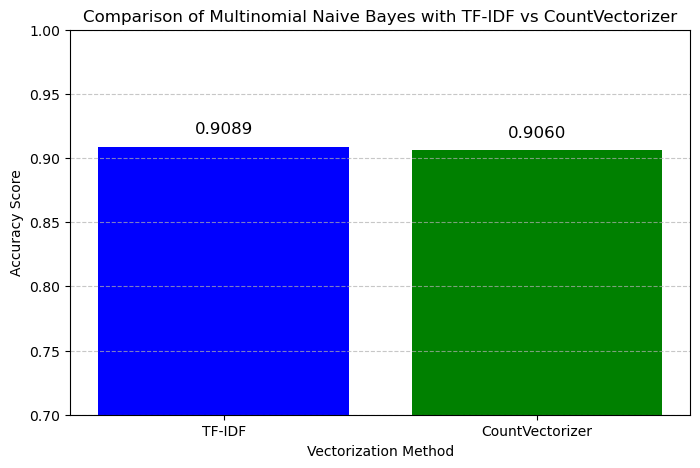

In [29]:
# Visualization of accuracy scores
models = list(accuracy_scores.keys())
scores = list(accuracy_scores.values())

plt.figure(figsize=(8, 5))
plt.bar(models, scores, color=['blue', 'green'])

plt.xlabel("Vectorization Method")
plt.ylabel("Accuracy Score")
plt.title("Comparison of Multinomial Naive Bayes with TF-IDF vs CountVectorizer")
plt.ylim(0.7, 1.0)  # Adjust based on your accuracy scores
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display values on bars
for i, v in enumerate(scores):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontsize=12)

plt.show()

## **Running ComplementNB with TF-IDF vectorizer**

In [16]:
from sklearn.naive_bayes import ComplementNB

# Initialize the vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data
X_train_cnb = vectorizer.fit_transform(X_train)
X_test_cnb = vectorizer.transform(X_test)

# Initialize Complement Naive Bayes classifier
cnb_tfidf = ComplementNB()
# Cross-validation

# Perform cross-validation on the training data
cv_scores = cross_val_score(cnb_tfidf, X_train_cnb, y_train, cv=5)  # 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean():.4f}")

# Grid Search
# Define the grid of hyperparameters

param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'norm': [True, False],
}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=cnb_tfidf, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV on the training data
grid_search.fit(X_train_cnb, y_train)

# Get the best hyperparameters
print(f"Best hyperparameters: {grid_search.best_params_}")

# Use the best model from grid search
cnb_tfidf = grid_search.best_estimator_

# Make predictions on the test data
y_pred = cnb_tfidf.predict(X_test_cnb)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Cross-validation scores: [0.86871955 0.86806515 0.86870743 0.86915582 0.86990717]
Mean cross-validation score: 0.8689
Best hyperparameters: {'alpha': 1.0, 'norm': True}
Accuracy: 0.8977
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.03      0.05     10552
           1       0.90      1.00      0.95     92596

    accuracy                           0.90    103148
   macro avg       0.70      0.51      0.50    103148
weighted avg       0.86      0.90      0.85    103148

